<a href="https://colab.research.google.com/github/ecuadrafoy/PracticalMachineLearning/blob/master/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Autoencoder
### Directives
* Create the autoencoders described below, you can play with the topology, those are just starting points
* Use GPU runtime
* Print 10 inputs and their associated outputs
* Don't forget to normalize your data
* Use the Functional API for Keras

### Autoencoders to build
1. Stacked 784 - 392 - 196 - 392 - 784 (tied weights)
2. Convolutional Encoder (conv, maxpool, conv, maxpool, conv, maxpool). Decoder (conv, upsample2d, conv, upsample2d, conv, upsample2d, conv)
3. Optional: GAN or VAE


## Loading Packages and Setting up the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from scipy.stats import norm
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Lambda, Reshape,Conv2DTranspose, MaxPool2D, ActivityRegularization
import tensorflow.keras.metrics
import tensorflow.keras.backend as K
from IPython import display



In [ ]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
def print_first_9(data):
  fig = plt.figure()
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(data[i], interpolation='none')
    plt.title("Digit: {}".format(i))
    plt.xticks([])
    plt.yticks([])

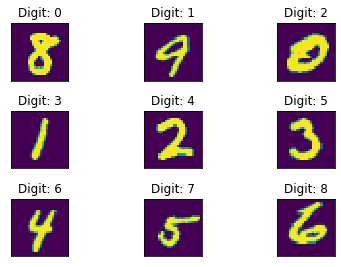

In [ ]:
print_first_9(x_test[-9:])

In [ ]:
#Plotting Images

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=x_test, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [ ]:
#Measure training time

from timeit import default_timer as timer

class TimingCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

cb = TimingCallback()

## A Simple Autoencoder

* A first my activation functions were done using `relu` but then i moved to `selu` and `sigmoid` and provided better intepretations

In [ ]:
K.clear_session()

input_img = Input(shape=(28,28))

#encoding
x = Flatten()(input_img) #it's the 784 neuron layer
x = Dense(392, activation ='selu')(x)
encoded = Dense(196, activation = 'selu')(x)

#decoding
x = Dense(392, activation = 'selu')(encoded)
x = Dense(784, activation= 'sigmoid')(x)
decoder = Reshape((28,28))(x)

m1 = Model(inputs = input_img, outputs = decoder)

m1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 392)               307720    
_________________________________________________________________
dense_1 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_2 (Dense)              (None, 392)               77224     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               308112    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0     

In [ ]:
#Using RMSprop gave me a blurb in the output
#Using Adam made all the outputs look like 3
#Using SGD was pretty good
m1.compile(loss = "binary_crossentropy", optimizer = tensorflow.keras.optimizers.SGD(lr=1.5))

In [ ]:
h1 = m1.fit(x_train,x_train, epochs=60, verbose=0, callbacks=[cb])
print(cb.logs)
print(sum(cb.logs))
    

[4.255691671000022, 3.773522064999952, 3.7869319240001005, 3.793584436999936, 3.7639604619998863, 3.778893532999973, 3.780086581999967, 3.771714349000149, 3.777107707000141, 3.7622894900000574, 3.764301064999927, 3.7859870390000196, 3.759280439000122, 3.7773988050000753, 3.772497322999925, 3.777438552999911, 3.7881014770000547, 3.77771391400006, 3.8241974019999816, 3.8205024970000068, 3.7677921449999303, 3.7869129910000083, 3.783739362000233, 3.778711629999634, 3.783241497999825, 3.760690435000015, 3.7722371400000156, 3.7509571000000506, 3.7647505300001285, 3.7679458409998006, 3.757331486000112, 3.790749044000222, 3.7576246539997555, 3.7757745760000034, 3.7710976540001866, 3.7814776840000377, 3.8309812889997374, 3.8628659129999505, 3.8832679279998956, 3.7647819989997515, 3.768017342999883, 3.800005166000119, 3.7652062669999395, 3.782177743000375, 3.7742749200001526, 3.841144045999954, 3.9394550100000743, 3.8723042050000913, 3.8662433939998664, 3.955814399999781, 3.858111823999934, 3.90

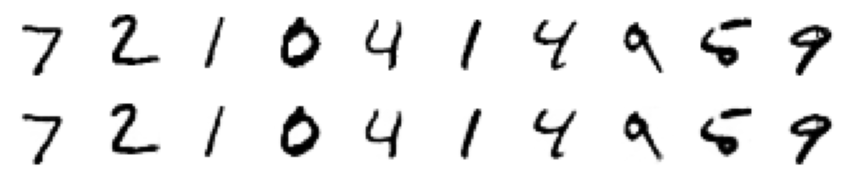

In [ ]:
show_reconstructions(m1)

## Visualizing MNIST


* Looking at Clusters 

In [ ]:
from sklearn.manifold import TSNE

x_compressed = m1.predict(x_test)

x_compressed = x_compressed.reshape(x_compressed.shape[0], -1)

tsne = TSNE()

X_test_2D = tsne.fit_transform(x_compressed)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

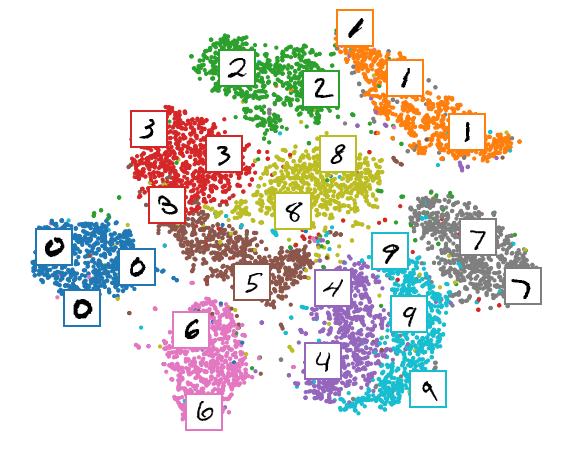

In [ ]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Autoencoders with Tying Weights

* A common technique when using symmetrical autoencoders is to tie the weights of the decoder layers to the weights of the encoder layers.
 * This halves ht enumber of weights in the model, speeding up training and limiting the risk of overfitting.
* Using tying weights provided the same kind of results and it took longer to process than without it. 
* 228 seconds vs 438

In [ ]:
#We need to create a custom layer to tie weights between the layers. This acts as a regular dense layer but it uses the transposed weights of the encoder's dense layer.
#This reduces the number of weights of the model and minimizes the risk of over-fitting. Should expect lower training times

class DenseTranspose(tensorflow.keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = tensorflow.keras.activations.get(activation)
    super().__init__(**kwargs)
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias", initializer="zeros",shape=[self.dense.input_shape[-1]])
    super().build(batch_input_shape)
  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.biases)

In [ ]:
K.clear_session()

dense1 = Dense(392, activation = 'selu')
dense2 = Dense(196, activation = 'selu')

input_img = Input(shape=(28,28))
x = Flatten()(input_img)
x = dense1(x)
x = dense2(x)

x = DenseTranspose(dense2, activation='selu')(x)
x = DenseTranspose(dense1, activation='sigmoid')(x)
out = Reshape([28,28])(x)

m2 = Model(inputs=input_img, outputs= out)

m2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 392)               307720    
_________________________________________________________________
dense_1 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_transpose (DenseTransp (None, 392)               77420     
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 784)               308504    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0     

In [ ]:
m2.compile(loss = "binary_crossentropy", optimizer = tensorflow.keras.optimizers.SGD(lr=1.5))

In [ ]:
h2 = m2.fit(x_train,x_train, epochs=60, verbose=0, callbacks=[cb])
print(cb.logs)
print(sum(cb.logs))

[4.255691671000022, 3.773522064999952, 3.7869319240001005, 3.793584436999936, 3.7639604619998863, 3.778893532999973, 3.780086581999967, 3.771714349000149, 3.777107707000141, 3.7622894900000574, 3.764301064999927, 3.7859870390000196, 3.759280439000122, 3.7773988050000753, 3.772497322999925, 3.777438552999911, 3.7881014770000547, 3.77771391400006, 3.8241974019999816, 3.8205024970000068, 3.7677921449999303, 3.7869129910000083, 3.783739362000233, 3.778711629999634, 3.783241497999825, 3.760690435000015, 3.7722371400000156, 3.7509571000000506, 3.7647505300001285, 3.7679458409998006, 3.757331486000112, 3.790749044000222, 3.7576246539997555, 3.7757745760000034, 3.7710976540001866, 3.7814776840000377, 3.8309812889997374, 3.8628659129999505, 3.8832679279998956, 3.7647819989997515, 3.768017342999883, 3.800005166000119, 3.7652062669999395, 3.782177743000375, 3.7742749200001526, 3.841144045999954, 3.9394550100000743, 3.8723042050000913, 3.8662433939998664, 3.955814399999781, 3.858111823999934, 3.90

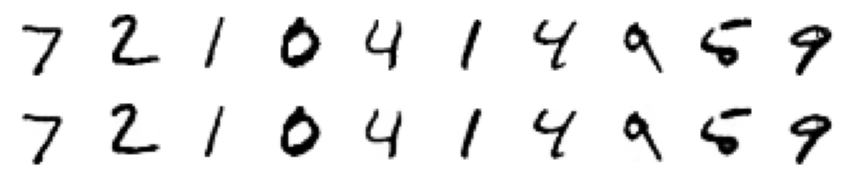

In [ ]:
show_reconstructions(m2)

## Convolutional Autoencoder
* CNNs are better suited than dense networks to work with images
* It reduces the spatial dimensionality of the inputs (height and width) while increasing the depth (number of feature maps).
*The decoder must do the reverse, upscale the image and reduce its depth back to the original dimensions

In [ ]:
K.clear_session()
input_img =Input(shape=(28,28))

#Encoding
x = Reshape([28,28,1])(input_img)
x = Conv2D(16,(3,3),padding="SAME", activation='selu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Conv2D(32,(3,3),padding="SAME", activation='selu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Conv2D(64,(3,3),padding="SAME", activation='selu')(x)
encoder = MaxPool2D(pool_size=2)(x)

#decoding
x = Conv2DTranspose(32, (3,3),strides=2, padding="VALID", activation="selu")(encoder)
x = Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu")(x)
x = Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid")(x)
decoder = Reshape([28,28])(x)

m3 = Model(input_img, decoder)
m3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496 

In [ ]:
m3.compile(loss="binary_crossentropy", optimizer=tensorflow.keras.optimizers.SGD(lr=1.5))

In [ ]:
h3 = m3.fit(x_train,x_train, epochs=60, verbose=0, callbacks=[cb])
print(cb.logs)
print(sum(cb.logs))
    

[4.255691671000022, 3.773522064999952, 3.7869319240001005, 3.793584436999936, 3.7639604619998863, 3.778893532999973, 3.780086581999967, 3.771714349000149, 3.777107707000141, 3.7622894900000574, 3.764301064999927, 3.7859870390000196, 3.759280439000122, 3.7773988050000753, 3.772497322999925, 3.777438552999911, 3.7881014770000547, 3.77771391400006, 3.8241974019999816, 3.8205024970000068, 3.7677921449999303, 3.7869129910000083, 3.783739362000233, 3.778711629999634, 3.783241497999825, 3.760690435000015, 3.7722371400000156, 3.7509571000000506, 3.7647505300001285, 3.7679458409998006, 3.757331486000112, 3.790749044000222, 3.7576246539997555, 3.7757745760000034, 3.7710976540001866, 3.7814776840000377, 3.8309812889997374, 3.8628659129999505, 3.8832679279998956, 3.7647819989997515, 3.768017342999883, 3.800005166000119, 3.7652062669999395, 3.782177743000375, 3.7742749200001526, 3.841144045999954, 3.9394550100000743, 3.8723042050000913, 3.8662433939998664, 3.955814399999781, 3.858111823999934, 3.90

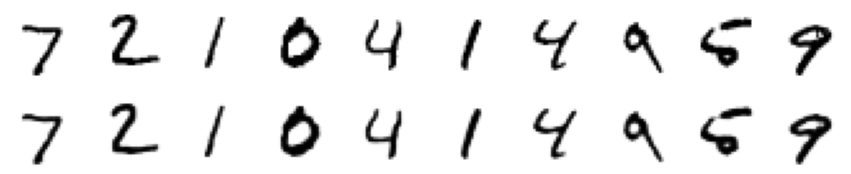

In [ ]:
show_reconstructions(m3)

In [ ]:
x_compressed = m3.predict(x_test)

x_compressed = x_compressed.reshape(x_compressed.shape[0], -1)

tsne = TSNE()

X_test_2D = tsne.fit_transform(x_compressed)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

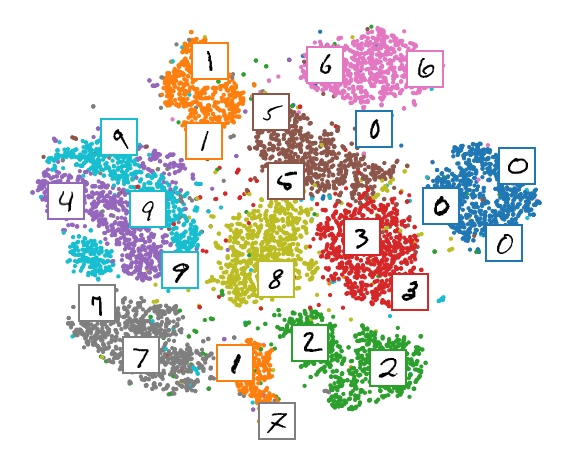

In [ ]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Sparse Autoencoder
* The autoencoder is pushed to reduce the number of active neurons in the coding layer. 
* We add some $l1$ regularization that adds a training loss equal to the sum of absolute value of its inputs. 
* Another approach is to measure actual sparsity of the coding layer at each training iteration and penalize the model when the measured sparsity differs from a target sparsity. 
* We want to penalize neuros that are too active or not active enough by adding a *sparsity loss* to the cost function. We can use the Kullback-Leibler divergence.


In [ ]:
K.clear_session()

input = Input(shape=(28,28))
x = Flatten()(input)
x = Dense(100, activation='selu')(x)
x = Dense(300, activation = 'sigmoid')(x)
encoder = ActivityRegularization(l1=1e-3)(x)

decoder = Dense(100, activation='selu')(encoder)
x = Dense(28*28, activation='sigmoid')(decoder)
output = Reshape([28,28])(x)

m4 = Model(input, output)

m4.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               30300     
_________________________________________________________________
activity_regularization (Act (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184 

In [ ]:
m4.compile(loss="binary_crossentropy", optimizer=tensorflow.keras.optimizers.SGD(lr=1.5))


In [ ]:
h4 = m4.fit(x_train,x_train, epochs=60, verbose=0, callbacks=[cb])
print(cb.logs)
print(sum(cb.logs))
    

[4.255691671000022, 3.773522064999952, 3.7869319240001005, 3.793584436999936, 3.7639604619998863, 3.778893532999973, 3.780086581999967, 3.771714349000149, 3.777107707000141, 3.7622894900000574, 3.764301064999927, 3.7859870390000196, 3.759280439000122, 3.7773988050000753, 3.772497322999925, 3.777438552999911, 3.7881014770000547, 3.77771391400006, 3.8241974019999816, 3.8205024970000068, 3.7677921449999303, 3.7869129910000083, 3.783739362000233, 3.778711629999634, 3.783241497999825, 3.760690435000015, 3.7722371400000156, 3.7509571000000506, 3.7647505300001285, 3.7679458409998006, 3.757331486000112, 3.790749044000222, 3.7576246539997555, 3.7757745760000034, 3.7710976540001866, 3.7814776840000377, 3.8309812889997374, 3.8628659129999505, 3.8832679279998956, 3.7647819989997515, 3.768017342999883, 3.800005166000119, 3.7652062669999395, 3.782177743000375, 3.7742749200001526, 3.841144045999954, 3.9394550100000743, 3.8723042050000913, 3.8662433939998664, 3.955814399999781, 3.858111823999934, 3.90

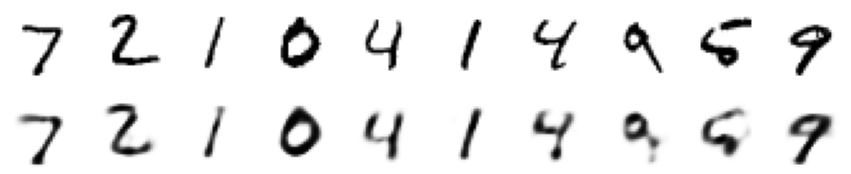

In [ ]:
show_reconstructions(m4)

In [ ]:
#Writing the KL Divergence for measurment of sparsity loss
kl_divergence = tensorflow.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tensorflow.keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [ ]:
#Building the sparse autoencoder using the KLDivergenceRegularizer

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)

K.clear_session()

input = Input(shape=(28,28))
x = Flatten()(input)
x = Dense(100, activation='selu')(x)
encoder = Dense(300, activation = 'sigmoid', activity_regularizer=kld_reg)(x)


decoder = Dense(100, activation='selu')(encoder)
x = Dense(28*28, activation='sigmoid')(decoder)
output = Reshape([28,28])(x)

m5 = Model(input, output)

m5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               30300     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0     

In [ ]:
m5.compile(loss="binary_crossentropy", optimizer=tensorflow.keras.optimizers.SGD(lr=1.5))


In [ ]:
h5 = m5.fit(x_train,x_train, epochs=60, verbose=0, callbacks=[cb])
print(cb.logs)
print(sum(cb.logs))
    

[4.255691671000022, 3.773522064999952, 3.7869319240001005, 3.793584436999936, 3.7639604619998863, 3.778893532999973, 3.780086581999967, 3.771714349000149, 3.777107707000141, 3.7622894900000574, 3.764301064999927, 3.7859870390000196, 3.759280439000122, 3.7773988050000753, 3.772497322999925, 3.777438552999911, 3.7881014770000547, 3.77771391400006, 3.8241974019999816, 3.8205024970000068, 3.7677921449999303, 3.7869129910000083, 3.783739362000233, 3.778711629999634, 3.783241497999825, 3.760690435000015, 3.7722371400000156, 3.7509571000000506, 3.7647505300001285, 3.7679458409998006, 3.757331486000112, 3.790749044000222, 3.7576246539997555, 3.7757745760000034, 3.7710976540001866, 3.7814776840000377, 3.8309812889997374, 3.8628659129999505, 3.8832679279998956, 3.7647819989997515, 3.768017342999883, 3.800005166000119, 3.7652062669999395, 3.782177743000375, 3.7742749200001526, 3.841144045999954, 3.9394550100000743, 3.8723042050000913, 3.8662433939998664, 3.955814399999781, 3.858111823999934, 3.90

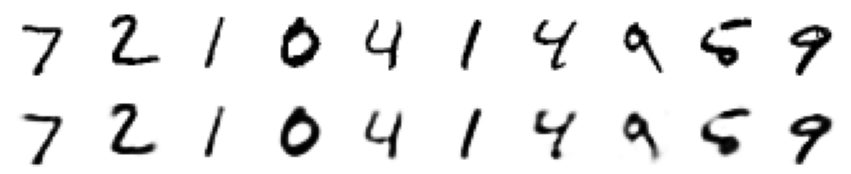

In [ ]:
show_reconstructions(m5)

## Variational Autoencoder

* Variational autoencoders are probabilistic, meaning that the outputs are partly determined by chance, even after training
  * They are also generative, they can new instances that look like they were sampled from the trianing set
  * Instead of producing a coding for a given input, the conder produces a *mean coding* $\mu$ and a standard deviation $\sigma$.
    * The actual coding is then sampled randomly from a Gaussian distribution with mean and  $\mu$ standard deviation $\sigma$
    * During training he cost function pushes the codings to migrate within the *latent space*

    

In [ ]:
#Creating the sampling
#Sampling layer takes two inputs, the mean and the log_var. It uses K.random_normal() to sample a random vector from normal distribution with mean 0 and std 1. 
class Sampling(tensorflow.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
K.clear_session()
codings_size = 10
#Encoder
input = Input(shape=[28, 28])
x = Flatten()(input)
x = Dense(392, activation="selu")(x)
x = Dense(196, activation="selu")(x)
codings_mean = Dense(codings_size)(x)  #This is mu
codings_log_var = Dense(codings_size)(x) #This is gamma. The two Dense layers that output codings have the same inputs and then we pass them to the sampling layer
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(
    inputs=[input], outputs=[codings_mean, codings_log_var, codings])

#Decoder

decoder_inputs = Input(shape=[codings_size])
x = Dense(196, activation="selu")(decoder_inputs)
x = Dense(392, activation="selu")(x)
x = Dense(28 * 28, activation="sigmoid")(x)
outputs = Reshape([28, 28])(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

#Putting the model together

_, _, codings = variational_encoder(input) # we ignore the first two outputs of the encoder, we only want to feeds the codings to the decoder
reconstructions = variational_decoder(codings)
m6 = Model(inputs=[input], outputs=[reconstructions])

m6.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
model (Model)                [(None, 10), (None, 10),  388688    
_________________________________________________________________
model_1 (Model)              (None, 28, 28)            387492    
Total params: 776,180
Trainable params: 776,180
Non-trainable params: 0
_________________________________________________________________


In [ ]:
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
m6.add_loss(K.mean(latent_loss) / 784.)
m6.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
h6 = m6.fit(x_train, x_train, epochs=50, batch_size=128,
                             validation_data=[x_test, x_test], verbose=0, callbacks=[cb])
print(sum(cb.logs))

1344.715395804009


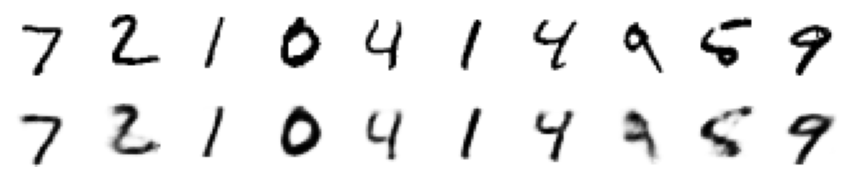

In [ ]:
show_reconstructions(m6)